In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

import pandas as pd
import numpy as np

# Create Stratified label fraction splits #

In [4]:
!ls /ds2/remote_sensing/ben-ge/ffcv/write_indices/

ben-ge-test60-delta.csv		     ben-ge-train60-delta_1_percent.csv
ben-ge-train60-delta.csv	     ben-ge-train60-delta_50_percent.csv
ben-ge-train60-delta_10_percent.csv  ben-ge-validation60-delta.csv


In [5]:
test_set_index_df = pd.read_csv("/ds2/remote_sensing/ben-ge/ffcv/write_indices/ben-ge-test60-delta.csv")
test_set_index_df = dd.from_pandas(test_set_index_df, chunksize=1000)

In [6]:
test_set_index_df.columns

Index(['patch_id', 'filename', 'tree_cover', 'shrubland', 'grassland',
       'cropland', 'built-up', 'bare/sparse_vegetation', 'snow_and_ice',
       'permanent_water_bodies', 'herbaceous_wetland', 'mangroves',
       'moss_and_lichen'],
      dtype='object')

In [7]:
test_set_index_df.head(3)

,patch_id,filename,tree_cover,shrubland,grassland,cropland,built-up,bare/sparse_vegetation,snow_and_ice,permanent_water_bodies,herbaceous_wetland,mangroves,moss_and_lichen
0,S2A_MSIL2A_20171221T112501_81_34,S2A_MSIL2A_20171221T112501_81_34_esaworldcover...,0.608125,0.158125,0.233333,0.000000,0.000000,0.000417,0.0,0.0,0.0,0.0,0.0
1,S2A_MSIL2A_20171002T112111_73_39,S2A_MSIL2A_20171002T112111_73_39_esaworldcover...,0.143264,0.000000,0.856667,0.000069,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,S2A_MSIL2A_20171221T112501_69_6,S2A_MSIL2A_20171221T112501_69_6_esaworldcover.tif,0.412500,0.230764,0.352500,0.000069,0.004167,0.000000,0.0,0.0,0.0,0.0,0.0


In [8]:
classification_threshold = 0.05
class_columns = [column for column in test_set_index_df.columns if column not in ["patch_id", "filename"]]

In [10]:
class_sums = test_set_index_df[class_columns].apply(lambda x: (x > classification_threshold).astype(int), axis=1, meta={k: "int64" for k in class_columns}).sum()
with ProgressBar():
    class_sum_results = class_sums.compute()

[########################################] | 100% Completed | 3.19 ss


### Original Distribution ###

In [12]:
(class_sum_results / class_sum_results.sum()).to_dict()

{'tree_cover': 0.34617318327725566,
 'shrubland': 0.021386858490930888,
 'grassland': 0.28912866921916697,
 'cropland': 0.16718876899872376,
 'built-up': 0.033917314460300885,
 'bare/sparse_vegetation': 0.002088409328228333,
 'snow_and_ice': 0.0,
 'permanent_water_bodies': 0.1288239161542329,
 'herbaceous_wetland': 0.010790114862513052,
 'mangroves': 0.0,
 'moss_and_lichen': 0.0005027652086475615}

## Sampling Methods ##

In [24]:
n = 100000

### Random Distribution ###

In [30]:
random_sample = ben_ge_index.sample(frac=(n / len(ben_ge_index)))

In [34]:
random_sample_class_sums = random_sample[class_columns].apply(lambda x: (x > classification_threshold).astype(int), axis=1, meta={k: "int64" for k in class_columns}).sum()

In [36]:
with ProgressBar():
    random_sample_class_sums_results = random_sample_class_sums.compute()

[########################################] | 100% Completed | 28.57 s


In [37]:
(random_sample_class_sums_results / random_sample_class_sums_results.sum())

tree_cover                0.347708
shrubland                 0.020732
grassland                 0.290300
cropland                  0.168799
built-up                  0.032591
bare/sparse_vegetation    0.001867
snow_and_ice              0.000000
permanent_water_bodies    0.126562
herbaceous_wetland        0.011207
mangroves                 0.000000
moss_and_lichen           0.000234
dtype: float64

### Max Label Fraction Sampling ###

In [72]:
classes_with_index = dd.from_pandas(pd.DataFrame(ben_ge_index_df[class_columns].idxmax(axis=1), columns=["max_class"]), chunksize=10000)

In [73]:
sampled_indices = classes_with_index.groupby("max_class").apply(lambda x: x.sample(frac=(n / len(ben_ge_index))))

/tmp/ipykernel_6350/2963205959.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  sampled_indices = classes_with_index.groupby("max_class").apply(lambda x: x.sample(frac=(n / len(ben_ge_index))))


In [74]:
with ProgressBar():
    sampled_indices_result = sampled_indices.compute()

[########################################] | 100% Completed | 1.82 sms


In [75]:
max_label_sampled_df = ben_ge_index.loc[sampled_indices_result.index]

In [78]:
max_label_sample_class_sums = max_label_sampled_df[class_columns].apply(lambda x: (x > classification_threshold).astype(int), axis=1, meta={k: "int64" for k in class_columns}).sum()

In [79]:
with ProgressBar():
    max_label_sample_class_sums_results = max_label_sample_class_sums.compute()

[########################################] | 100% Completed | 32.53 s


In [80]:
max_label_sample_class_sums_results / max_label_sample_class_sums_results.sum()

tree_cover                0.348663
shrubland                 0.020921
grassland                 0.289945
cropland                  0.168374
built-up                  0.032981
bare/sparse_vegetation    0.001914
snow_and_ice              0.000000
permanent_water_bodies    0.126383
herbaceous_wetland        0.010634
mangroves                 0.000000
moss_and_lichen           0.000185
dtype: float64

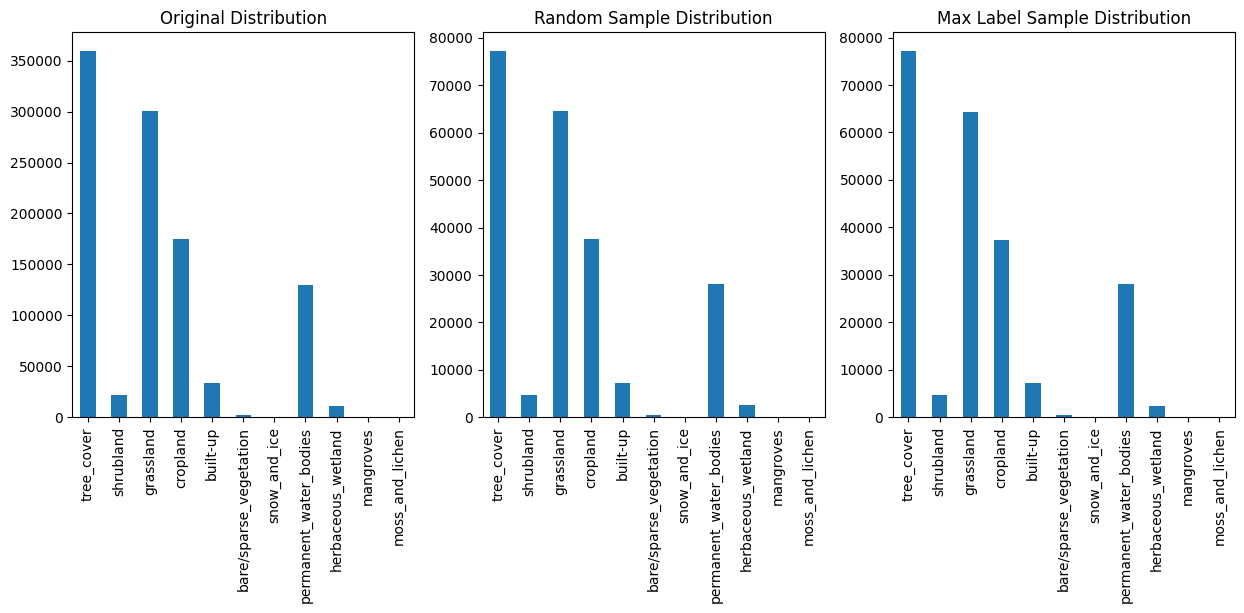

In [91]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

i = 0
for k, v in {
    "Original Distribution": class_sum_results, 
    "Random Sample Distribution": random_sample_class_sums_results,
    "Max Label Sample Distribution": max_label_sample_class_sums_results
}.items():
    ax = axs[i]
    ax.set_title(k)
    v.plot.bar(ax=ax)
    i +=1

## Stratified Sampling for Benge 60-Delta ##

In [148]:
!ls /ds2/remote_sensing/ben-ge/ffcv/write_indices

ben-ge-test60-delta.csv		     ben-ge-train60-delta_1_percent.csv
ben-ge-train60-delta.csv	     ben-ge-train60-delta_50_percent.csv
ben-ge-train60-delta_10_percent.csv  ben-ge-validation60-delta.csv


In [126]:
fractions = sorted([.01, 0.1, 0.5], reverse=True)
benge_ge_60_d_train = pd.read_csv("/ds2/remote_sensing/ben-ge/ffcv/write_indices/ben-ge-train60-delta.csv")

In [109]:
benge_ge_60_d_train.head(3)

,patch_id,filename,tree_cover,shrubland,grassland,cropland,built-up,bare/sparse_vegetation,snow_and_ice,permanent_water_bodies,herbaceous_wetland,mangroves,moss_and_lichen
0,S2B_MSIL2A_20170709T094029_7_54,S2B_MSIL2A_20170709T094029_7_54_esaworldcover.tif,0.571111,0.000000,0.086667,0.328819,0.008056,0.000069,0.0,0.000000,0.005278,0.0,0.0
1,S2B_MSIL2A_20170814T100029_84_63,S2B_MSIL2A_20170814T100029_84_63_esaworldcover...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0
2,S2A_MSIL2A_20171002T112112_64_39,S2A_MSIL2A_20171002T112112_64_39_esaworldcover...,0.018542,0.001319,0.922083,0.054792,0.002222,0.000000,0.0,0.001042,0.000000,0.0,0.0


In [132]:
fraction_samples = {}
fraction_df = benge_ge_60_d_train.copy()
single_class_label_key = "single_class_label"
for fraction in fractions:
    single_class_labels = pd.DataFrame(fraction_df[class_columns].idxmax(axis=1), columns=[single_class_label_key])
    samples = single_class_labels.groupby(single_class_label_key).apply(lambda x: x.sample(frac=fraction))
    sample_indices = samples.index.get_level_values(1)
    fraction_samples[fraction] = fraction_df.iloc[sample_indices]

In [134]:
fraction_samples[0.01].head(3)

,patch_id,filename,tree_cover,shrubland,grassland,cropland,built-up,bare/sparse_vegetation,snow_and_ice,permanent_water_bodies,herbaceous_wetland,mangroves,moss_and_lichen
48424,S2B_MSIL2A_20170914T93030_75_77,S2B_MSIL2A_20170914T93030_75_77_esaworldcover.tif,0.187569,0.0,0.148125,0.159375,0.504097,0.000833,0.0,0.000000,0.0,0.0,0.0
85485,S2A_MSIL2A_20180413T095031_9_24,S2A_MSIL2A_20180413T095031_9_24_esaworldcover.tif,0.295208,0.0,0.169514,0.024792,0.503403,0.001042,0.0,0.006042,0.0,0.0,0.0
16428,S2B_MSIL2A_20171206T094349_70_49,S2B_MSIL2A_20171206T094349_70_49_esaworldcover...,0.163472,0.0,0.237083,0.250903,0.348542,0.000000,0.0,0.000000,0.0,0.0,0.0


In [149]:
for k, v in fraction_samples.items():
    v.to_csv(f"/ds2/remote_sensing/ben-ge/ffcv/write_indices/ben-ge-train60-delta_{int(k*100)}_percent.csv", index=False)